## 2023 Open Science Data Challenge - Level 1
## NDVI Data Gathering From Landsat Collection 2 Level 2
## Team: Devashish Mahajan

### Team Members:
### 1) Devashish Mahajan
### 2) Rohit Chaudhari

This notebook collects Normalized Difference Vegetation Index (NDVI) data from Landsat Collection 2 Level 2 data. Function "get_landsat_data" return NDVI for given latitude and longitude.
 

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import pandas as pd
from tqdm import tqdm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio
import xrspatial.multispectral as ms

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load
from odc.algo import to_rgba

In [2]:
# Read crop location trainig data file
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv") 
print(crop_presence_data.info())
print(crop_presence_data['Class of Land'].value_counts())
print(crop_presence_data.head())
print(crop_presence_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Latitude and Longitude  600 non-null    object
 1   Class of Land           600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
None
Rice        300
Non Rice    300
Name: Class of Land, dtype: int64
                     Latitude and Longitude Class of Land
0   (10.323727047081501, 105.2516346045924)          Rice
1  (10.322364360592521, 105.27843410554115)          Rice
2  (10.321455902933202, 105.25254306225168)          Rice
3  (10.324181275911162, 105.25118037576274)          Rice
4  (10.324635504740822, 105.27389181724476)          Rice
                       Latitude and Longitude Class of Land
595  (10.013942985253381, 105.67361318732796)      Non Rice
596   (10.01348875642372, 105.67361318732796)      Non Rice
597  (10.013034527594062, 105.67361318732796)    

In [3]:
def get_landsat_data(latlong,time_slice,assets):
    '''
    Returns NDVI values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the NDVI values have to be extracted
    assets - A list of bands to be extracted
    '''
    
    lat_long=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    box_size_deg = 0.010 # Surrounding box in degrees
    
    
    # Calculate the Lat-Lon bounding box region
    min_lon = float(lat_long[1])-box_size_deg/2
    min_lat = float(lat_long[0])-box_size_deg/2
    max_lon = float(lat_long[1])+box_size_deg/2
    max_lat = float(lat_long[0])+box_size_deg/2
    bounds = (min_lon, min_lat, max_lon, max_lat)
    
    # Define the time window    
    time_of_interest = time_slice 
    #print(time_of_interest)
    
    
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
    collections=["landsat-c2-l2"], 
    bbox=bounds, 
    datetime = time_slice,
    query={"platform": {"in": ["landsat-8", "landsat-9"]},},
        )
    items = list(search.get_all_items())
    #print('This is the number of scenes that touch our region:',len(items))

    # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees
    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

    xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
    )

    # Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
    # https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
    xx['red'] = (xx['red']*0.0000275)-0.2
    xx['green'] = (xx['green']*0.0000275)-0.2
    xx['blue'] = (xx['blue']*0.0000275)-0.2
    xx['nir08'] = (xx['nir08']*0.0000275)-0.2
    

    # To mask the pixels and find clouds or water, it is best to use the bit values of the 16-bit qa_pixel flag
    # See the website above for a nice explanation of the process

    bit_flags = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2, 
            'cloud': 1<<3,
            'shadow': 1<<4, 
            'snow': 1<<5, 
            'clear': 1<<6,
            'water': 1<<7 
    }
    
    
    # Create a function that will mask pixels with a given type
    def get_mask(mask, flags_list):
    
        # Create the result mask filled with zeros and the same shape as the mask
        final_mask = np.zeros_like(mask)
    
        # Loop through the flags  
        for flag in flags_list:
        
            # get the mask for each flag
            flag_mask = np.bitwise_and(mask, bit_flags[flag])
        
            # add it to the final flag
            final_mask = final_mask | flag_mask
    
        return final_mask > 0


    # Calculate the mask for the entire xarray (all time slices)
    full_mask = get_mask(xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow', 'water'])
    
    # Create a "clean" dataset with the mask applied 
    cleaned_data = xx.where(~full_mask)
    
    # Calculate the mean of the data across the sample region and then NDVI
    # Perform this calculation for the unfiltered and cloud-filtered (clean) datasets
    mean_unfiltered = xx.mean(dim=['longitude','latitude']).compute()
    ndvi_mean = (mean_unfiltered.nir08-mean_unfiltered.red)/(mean_unfiltered.nir08+mean_unfiltered.red)
    mean_clean = cleaned_data.mean(dim=['longitude','latitude']).compute()
    ndvi_mean_clean = (mean_clean.nir08-mean_clean.red)/(mean_clean.nir08+mean_clean.red)
    
    return ndvi_mean_clean.to_numpy()
    

## Note: 

All of the training and test data will assume triple cropping (3 cycles per year)
with a focus on the Winter-Spring 2021-2022 season (November to April)
and the Summer-Autumn 2022 season (April to August) 
### November 2021 to April 2022    ==  2021-11-01 to 2022-04-30
### April 2022 to August 2022  ==  2022-04-01 to 2022-08-31
### Combining above both seasons  2021-11-01 to 2022-08-31

Planting occurs within the first 2 months of each cycle (depending on location) 
and harvesting occurs within the last 2 months of each cycle"""

## NDVI Data Gathering for "crop_presence_data" File

In [4]:
## Function call to extract NDVI Values

time_slice = "2021-11-01/2022-05-30"  
assests = ['vh','vv']
NDVI = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    #print("return",get_landsat_data(coordinates,time_slice,assests))
    NDVI.append(get_landsat_data(coordinates,time_slice,assests))

100%|██████████| 600/600 [1:00:05<00:00,  6.01s/it]


In [5]:
NDVI_data = pd.DataFrame(NDVI,columns = ['ndvi1','ndvi2','ndvi3','ndvi4','ndvi5',
                                          'ndvi6','ndvi7','ndvi8','ndvi9','ndvi10',
                                          'ndvi11','ndvi12','ndvi13','ndvi14','ndvi15',
                                          'ndvi16','ndvi17','ndvi18', 'ndvi19','ndvi20',
                                          'ndvi21','ndvi22','ndvi23','ndvi24','ndvi25',
                                          'ndvi26','ndvi27','ndvi28','ndvi29','ndvi30',
                                          'ndvi31' ,'ndvi32','ndvi33','ndvi34','ndvi35',
                                          'ndvi36','ndvi37','ndvi38','ndvi39','ndvi40',
                                          'ndvi41','ndvi42','ndvi43'])

In [6]:
NDVI_data[0:1]

,ndvi1,ndvi2,ndvi3,ndvi4,ndvi5,ndvi6,ndvi7,ndvi8,ndvi9,ndvi10,...,ndvi34,ndvi35,ndvi36,ndvi37,ndvi38,ndvi39,ndvi40,ndvi41,ndvi42,ndvi43
0,0.686632,NaN,NaN,NaN,NaN,NaN,0.229253,0.233093,0.193175,0.259608,...,NaN,NaN,0.536599,NaN,0.543885,0.699072,NaN,NaN,NaN,NaN


In [7]:
NDVI_data.isnull().sum()

ndvi1     110
ndvi2     600
ndvi3     493
ndvi4     323
ndvi5     250
ndvi6     228
ndvi7     250
ndvi8      50
ndvi9      23
ndvi10    133
ndvi11      0
ndvi12    300
ndvi13    500
ndvi14    292
ndvi15    322
ndvi16    273
ndvi17    265
ndvi18    178
ndvi19    143
ndvi20    312
ndvi21    350
ndvi22    600
ndvi23    543
ndvi24    450
ndvi25    600
ndvi26    450
ndvi27    600
ndvi28    600
ndvi29    475
ndvi30    450
ndvi31    600
ndvi32    450
ndvi33    450
ndvi34    598
ndvi35    479
ndvi36    450
ndvi37    600
ndvi38    516
ndvi39    450
ndvi40    600
ndvi41    502
ndvi42    600
ndvi43    600
dtype: int64

In [8]:
# Impute data to fill NaN values
NDVI_data.interpolate(method='linear',axis=1, inplace=True)
NDVI_data.interpolate(method='linear',limit_direction='backward',axis=1, inplace=True)

In [9]:
NDVI_data.isnull().sum()

ndvi1     0
ndvi2     0
ndvi3     0
ndvi4     0
ndvi5     0
ndvi6     0
ndvi7     0
ndvi8     0
ndvi9     0
ndvi10    0
ndvi11    0
ndvi12    0
ndvi13    0
ndvi14    0
ndvi15    0
ndvi16    0
ndvi17    0
ndvi18    0
ndvi19    0
ndvi20    0
ndvi21    0
ndvi22    0
ndvi23    0
ndvi24    0
ndvi25    0
ndvi26    0
ndvi27    0
ndvi28    0
ndvi29    0
ndvi30    0
ndvi31    0
ndvi32    0
ndvi33    0
ndvi34    0
ndvi35    0
ndvi36    0
ndvi37    0
ndvi38    0
ndvi39    0
ndvi40    0
ndvi41    0
ndvi42    0
ndvi43    0
dtype: int64

In [10]:
# Take look of first 5 rows
NDVI_data.head()

,ndvi1,ndvi2,ndvi3,ndvi4,ndvi5,ndvi6,ndvi7,ndvi8,ndvi9,ndvi10,...,ndvi34,ndvi35,ndvi36,ndvi37,ndvi38,ndvi39,ndvi40,ndvi41,ndvi42,ndvi43
0,0.686632,0.610402,0.534172,0.457942,0.381712,0.305482,0.229253,0.233093,0.193175,0.259608,...,0.313382,0.424991,0.536599,0.540242,0.543885,0.699072,0.699072,0.699072,0.699072,0.699072
1,0.659306,0.580200,0.501093,0.421987,0.342880,0.263774,0.184667,0.203444,0.256401,0.281771,...,0.282769,0.422064,0.554025,0.621165,0.688304,0.677295,0.677295,0.677295,0.677295,0.677295
2,0.696930,0.617363,0.537795,0.458228,0.378660,0.299092,0.219525,0.220143,0.209674,0.269206,...,0.317064,0.429968,0.542872,0.525434,0.507996,0.689550,0.718553,0.747556,0.747556,0.747556
3,0.697329,0.618965,0.540601,0.462237,0.383872,0.305508,0.227144,0.233915,0.187839,0.261203,...,0.195365,0.188005,0.520622,0.552399,0.584176,0.693076,0.693076,0.693076,0.693076,0.693076
4,0.197278,0.197278,0.197278,0.197278,0.197278,0.197278,0.197278,0.199387,0.252192,0.295250,...,0.351093,0.485434,0.547099,0.561733,0.576367,0.533911,0.533911,0.533911,0.533911,0.533911


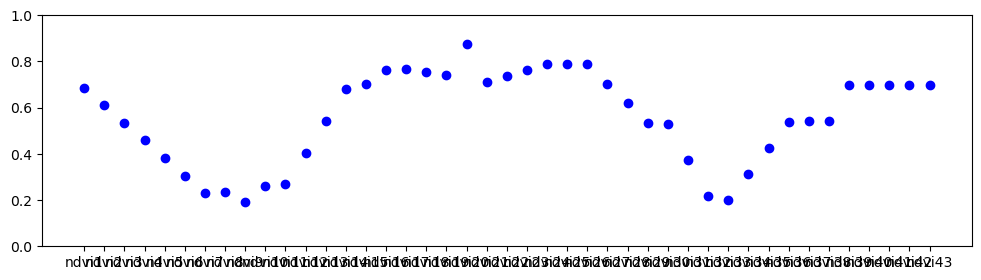

In [11]:
x = NDVI_data[0:1]
y = ['ndvi1','ndvi2','ndvi3','ndvi4','ndvi5', 'ndvi6','ndvi7','ndvi8','ndvi9','ndvi10',
     'ndvi11','ndvi12','ndvi13','ndvi14','ndvi15', 'ndvi16','ndvi17','ndvi18', 'ndvi19','ndvi20',
    'ndvi21','ndvi22','ndvi23','ndvi24','ndvi25', 'ndvi26','ndvi27','ndvi28','ndvi29','ndvi30',
    'ndvi31' ,'ndvi32','ndvi33','ndvi34','ndvi35', 'ndvi36','ndvi37','ndvi38','ndvi39','ndvi40',
    'ndvi41','ndvi42','ndvi43']
plt.figure(figsize=(12,3))
plt.ylim(0.0 , 1.0)
plt.scatter(y,x, c ="blue");

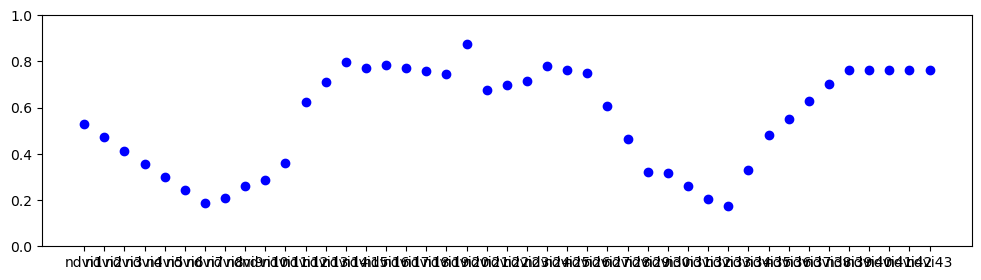

In [12]:
x = NDVI_data[5:6]
plt.figure(figsize=(12,3))
plt.ylim(0.0 , 1.0)
plt.scatter(y,x, c ="blue");

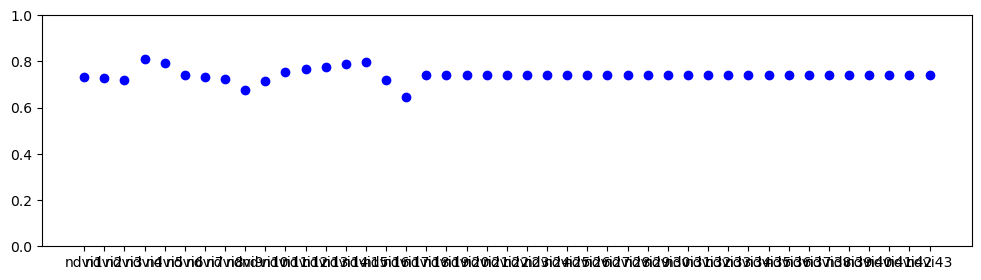

In [13]:
x = NDVI_data[-2:-1]
plt.figure(figsize=(12,3))
plt.ylim(0.0 , 1.0)
plt.scatter(y,x, c ="blue");

In [14]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [15]:
crop_data = combine_two_datasets(crop_presence_data,NDVI_data)
crop_data.head()

,Latitude and Longitude,Class of Land,ndvi1,ndvi2,ndvi3,ndvi4,ndvi5,ndvi6,ndvi7,ndvi8,...,ndvi34,ndvi35,ndvi36,ndvi37,ndvi38,ndvi39,ndvi40,ndvi41,ndvi42,ndvi43
0,"(10.323727047081501, 105.2516346045924)",Rice,0.686632,0.610402,0.534172,0.457942,0.381712,0.305482,0.229253,0.233093,...,0.313382,0.424991,0.536599,0.540242,0.543885,0.699072,0.699072,0.699072,0.699072,0.699072
1,"(10.322364360592521, 105.27843410554115)",Rice,0.659306,0.580200,0.501093,0.421987,0.342880,0.263774,0.184667,0.203444,...,0.282769,0.422064,0.554025,0.621165,0.688304,0.677295,0.677295,0.677295,0.677295,0.677295
2,"(10.321455902933202, 105.25254306225168)",Rice,0.696930,0.617363,0.537795,0.458228,0.378660,0.299092,0.219525,0.220143,...,0.317064,0.429968,0.542872,0.525434,0.507996,0.689550,0.718553,0.747556,0.747556,0.747556
3,"(10.324181275911162, 105.25118037576274)",Rice,0.697329,0.618965,0.540601,0.462237,0.383872,0.305508,0.227144,0.233915,...,0.195365,0.188005,0.520622,0.552399,0.584176,0.693076,0.693076,0.693076,0.693076,0.693076
4,"(10.324635504740822, 105.27389181724476)",Rice,0.197278,0.197278,0.197278,0.197278,0.197278,0.197278,0.197278,0.199387,...,0.351093,0.485434,0.547099,0.561733,0.576367,0.533911,0.533911,0.533911,0.533911,0.533911


In [16]:
crop_data.to_csv('crop_data_landsat_cloud_filter_ndvi_43Columns_2021-11-01_2022-05-30.csv',index = False)  

## NDVI Data Gathering for "challenge_1_submission_template_correct_columns_fixed" File

In [17]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template_correct_columns_fixed.csv')
print(test_file.shape)
test_file.head() 

(250, 2)


,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [18]:
## Function call to extract VV,VH Values

time_slice = "2021-11-01/2022-05-30"  
assests = ['vh','vv']
ndvi = []
for coordinates in tqdm(test_file['id']):
    #print("return",get_landsat_data(coordinates,time_slice,assests))
    ndvi.append(get_landsat_data(coordinates,time_slice,assests))

100%|██████████| 250/250 [35:03<00:00,  8.42s/it]


In [19]:
submission_ndvi_data = pd.DataFrame(ndvi,columns =   ['ndvi1','ndvi2','ndvi3','ndvi4','ndvi5',
                                                      'ndvi6','ndvi7','ndvi8','ndvi9','ndvi10',
                                                      'ndvi11','ndvi12','ndvi13','ndvi14','ndvi15',
                                                      'ndvi16','ndvi17','ndvi18', 'ndvi19','ndvi20',
                                                      'ndvi21','ndvi22','ndvi23','ndvi24','ndvi25',
                                                      'ndvi26','ndvi27','ndvi28','ndvi29','ndvi30',
                                                      'ndvi31' ,'ndvi32','ndvi33','ndvi34','ndvi35',
                                                      'ndvi36','ndvi37','ndvi38','ndvi39','ndvi40',
                                                      'ndvi41','ndvi42','ndvi43','ndvi44','ndvi45',
                                                      'ndvi46','ndvi47','ndvi48','ndvi49','ndvi50',
                                                      'ndvi51','ndvi52','ndvi53','ndvi54','ndvi55',
                                                      'ndvi56','ndvi57','ndvi58','ndvi59','ndvi60',
                                                      'ndvi61','ndvi62','ndvi63','ndvi64','ndvi65'
                                                       ] )

In [20]:
submission_ndvi_data.head()

,ndvi1,ndvi2,ndvi3,ndvi4,ndvi5,ndvi6,ndvi7,ndvi8,ndvi9,ndvi10,...,ndvi56,ndvi57,ndvi58,ndvi59,ndvi60,ndvi61,ndvi62,ndvi63,ndvi64,ndvi65
0,0.034391,NaN,NaN,NaN,NaN,NaN,NaN,0.137486,0.280228,0.401420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.389868,NaN,0.370443,NaN,NaN,0.161734,NaN,0.582780,0.805053,0.820882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.396187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.442594,0.439468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.495364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.396489,...,NaN,NaN,NaN,0.410426,0.31475,0.506171,NaN,NaN,NaN,NaN
4,0.210720,NaN,NaN,NaN,NaN,NaN,0.266389,0.358225,0.723914,0.825480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
submission_ndvi_data.isnull().sum()

ndvi1      52
ndvi2     250
ndvi3     202
ndvi4     157
ndvi5     166
         ... 
ndvi61    225
ndvi62    250
ndvi63    250
ndvi64    250
ndvi65    250
Length: 65, dtype: int64

In [22]:
submission_ndvi_data[['ndvi1','ndvi2','ndvi3','ndvi4','ndvi5',
                    'ndvi6','ndvi7','ndvi8','ndvi9','ndvi10',
                    'ndvi11','ndvi12','ndvi13','ndvi14','ndvi15',
                    'ndvi16','ndvi17','ndvi18', 'ndvi19','ndvi20',
                    'ndvi21','ndvi22','ndvi23','ndvi24','ndvi25',
                    'ndvi26','ndvi27','ndvi28','ndvi29','ndvi30',
                    'ndvi31' ,'ndvi32','ndvi33','ndvi34','ndvi35',
                    'ndvi36','ndvi37','ndvi38','ndvi39','ndvi40',
                    'ndvi41','ndvi42','ndvi43']].isnull().sum()

ndvi1      52
ndvi2     250
ndvi3     202
ndvi4     157
ndvi5     166
ndvi6     160
ndvi7     111
ndvi8     104
ndvi9      54
ndvi10     41
ndvi11     23
ndvi12    142
ndvi13    146
ndvi14     76
ndvi15    103
ndvi16    113
ndvi17     91
ndvi18      6
ndvi19     78
ndvi20     85
ndvi21     62
ndvi22    151
ndvi23    128
ndvi24    153
ndvi25    196
ndvi26    159
ndvi27    153
ndvi28    152
ndvi29    147
ndvi30    150
ndvi31    200
ndvi32    142
ndvi33    156
ndvi34    170
ndvi35    121
ndvi36    127
ndvi37    154
ndvi38    164
ndvi39    149
ndvi40    192
ndvi41    232
ndvi42    220
ndvi43    209
dtype: int64

In [23]:
submission_ndvi_data[['ndvi44','ndvi45','ndvi46','ndvi47','ndvi48','ndvi49','ndvi50',
                    'ndvi51','ndvi52','ndvi53','ndvi54','ndvi55', 'ndvi56','ndvi57','ndvi58','ndvi59','ndvi60',
                                        'ndvi61','ndvi62','ndvi63','ndvi64','ndvi65']].isnull().sum()

ndvi44    200
ndvi45    225
ndvi46    225
ndvi47    250
ndvi48    225
ndvi49    225
ndvi50    225
ndvi51    225
ndvi52    225
ndvi53    250
ndvi54    250
ndvi55    225
ndvi56    250
ndvi57    250
ndvi58    250
ndvi59    225
ndvi60    225
ndvi61    225
ndvi62    250
ndvi63    250
ndvi64    250
ndvi65    250
dtype: int64

In [24]:
# Columns from ndvi 44 to ndvi 65 has most of NaN values so droping that columns
submission_ndvi_data = submission_ndvi_data[ ['ndvi1','ndvi2','ndvi3','ndvi4','ndvi5',
                                          'ndvi6','ndvi7','ndvi8','ndvi9','ndvi10',
                                          'ndvi11','ndvi12','ndvi13','ndvi14','ndvi15',
                                          'ndvi16','ndvi17','ndvi18', 'ndvi19','ndvi20',
                                          'ndvi21','ndvi22','ndvi23','ndvi24','ndvi25',
                                          'ndvi26','ndvi27','ndvi28','ndvi29','ndvi30',
                                          'ndvi31' ,'ndvi32','ndvi33','ndvi34','ndvi35',
                                          'ndvi36','ndvi37','ndvi38','ndvi39','ndvi40',
                                          'ndvi41','ndvi42','ndvi43']]

In [25]:
submission_ndvi_data.isnull().sum()

ndvi1      52
ndvi2     250
ndvi3     202
ndvi4     157
ndvi5     166
ndvi6     160
ndvi7     111
ndvi8     104
ndvi9      54
ndvi10     41
ndvi11     23
ndvi12    142
ndvi13    146
ndvi14     76
ndvi15    103
ndvi16    113
ndvi17     91
ndvi18      6
ndvi19     78
ndvi20     85
ndvi21     62
ndvi22    151
ndvi23    128
ndvi24    153
ndvi25    196
ndvi26    159
ndvi27    153
ndvi28    152
ndvi29    147
ndvi30    150
ndvi31    200
ndvi32    142
ndvi33    156
ndvi34    170
ndvi35    121
ndvi36    127
ndvi37    154
ndvi38    164
ndvi39    149
ndvi40    192
ndvi41    232
ndvi42    220
ndvi43    209
dtype: int64

In [26]:
submission_ndvi_data.interpolate(method='linear',axis=1, inplace=True)
submission_ndvi_data.interpolate(method='linear',limit_direction='backward',axis=1, inplace=True)

In [27]:
submission_ndvi_data.isnull().sum()

ndvi1     0
ndvi2     0
ndvi3     0
ndvi4     0
ndvi5     0
ndvi6     0
ndvi7     0
ndvi8     0
ndvi9     0
ndvi10    0
ndvi11    0
ndvi12    0
ndvi13    0
ndvi14    0
ndvi15    0
ndvi16    0
ndvi17    0
ndvi18    0
ndvi19    0
ndvi20    0
ndvi21    0
ndvi22    0
ndvi23    0
ndvi24    0
ndvi25    0
ndvi26    0
ndvi27    0
ndvi28    0
ndvi29    0
ndvi30    0
ndvi31    0
ndvi32    0
ndvi33    0
ndvi34    0
ndvi35    0
ndvi36    0
ndvi37    0
ndvi38    0
ndvi39    0
ndvi40    0
ndvi41    0
ndvi42    0
ndvi43    0
dtype: int64

In [28]:
submission_ndvi_data.head()

,ndvi1,ndvi2,ndvi3,ndvi4,ndvi5,ndvi6,ndvi7,ndvi8,ndvi9,ndvi10,...,ndvi34,ndvi35,ndvi36,ndvi37,ndvi38,ndvi39,ndvi40,ndvi41,ndvi42,ndvi43
0,0.034391,0.049119,0.063847,0.078574,0.093302,0.108030,0.122758,0.137486,0.280228,0.401420,...,0.664195,0.552815,0.754318,0.754318,0.754318,0.754318,0.754318,0.754318,0.754318,0.754318
1,0.389868,0.380155,0.370443,0.300873,0.231303,0.161734,0.372257,0.582780,0.805053,0.820882,...,0.746475,0.746475,0.746475,0.746475,0.746475,0.746475,0.746475,0.746475,0.746475,0.746475
2,0.396187,0.401987,0.407788,0.413589,0.419390,0.425191,0.430992,0.436793,0.442594,0.439468,...,0.337975,0.341415,0.359307,0.366807,0.405334,0.409349,0.483221,0.557093,0.630966,0.680659
3,0.495364,0.484378,0.473392,0.462406,0.451420,0.440434,0.429447,0.418461,0.407475,0.396489,...,0.494605,0.504675,0.370998,0.441522,0.455421,0.469319,0.468331,0.468331,0.468331,0.468331
4,0.210720,0.219998,0.229276,0.238554,0.247832,0.257111,0.266389,0.358225,0.723914,0.825480,...,0.710758,0.808364,0.777354,0.774209,0.771064,0.767918,0.767918,0.767918,0.767918,0.767918


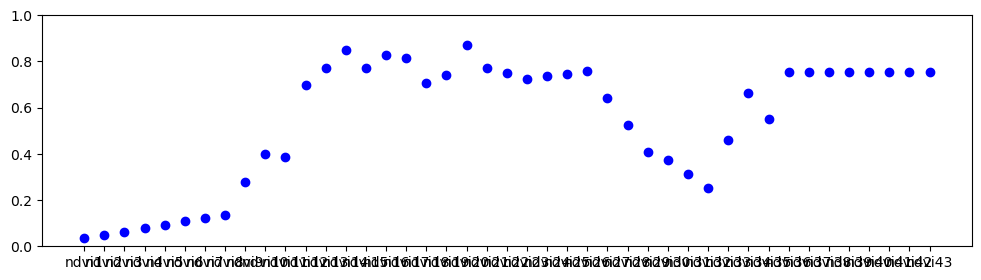

In [29]:
import matplotlib.pyplot as plt
x = submission_ndvi_data[0:1]
y = ['ndvi1','ndvi2','ndvi3','ndvi4','ndvi5', 'ndvi6','ndvi7','ndvi8','ndvi9','ndvi10',
    'ndvi11','ndvi12','ndvi13','ndvi14','ndvi15','ndvi16','ndvi17','ndvi18', 'ndvi19','ndvi20',
    'ndvi21','ndvi22','ndvi23','ndvi24','ndvi25','ndvi26','ndvi27','ndvi28','ndvi29','ndvi30',
    'ndvi31' ,'ndvi32','ndvi33','ndvi34','ndvi35', 'ndvi36','ndvi37','ndvi38','ndvi39','ndvi40',
                                          'ndvi41','ndvi42','ndvi43']
plt.figure(figsize=(12,3))
plt.ylim(0.0 , 1.0)
plt.scatter(y,x, c ="blue");

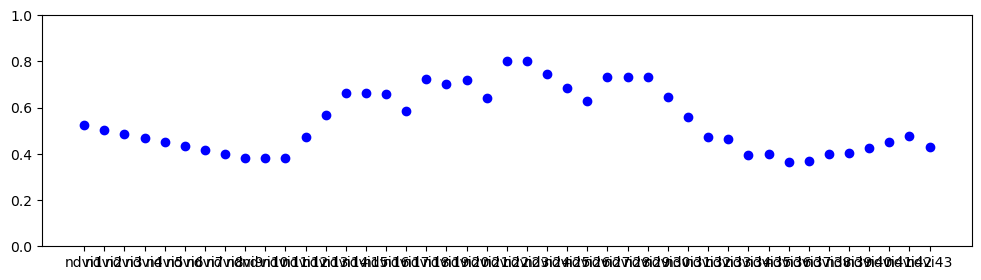

In [30]:
x = submission_ndvi_data[-2:-1]
plt.figure(figsize=(12,3))
plt.ylim(0.0 , 1.0)
plt.scatter(y,x, c ="blue");

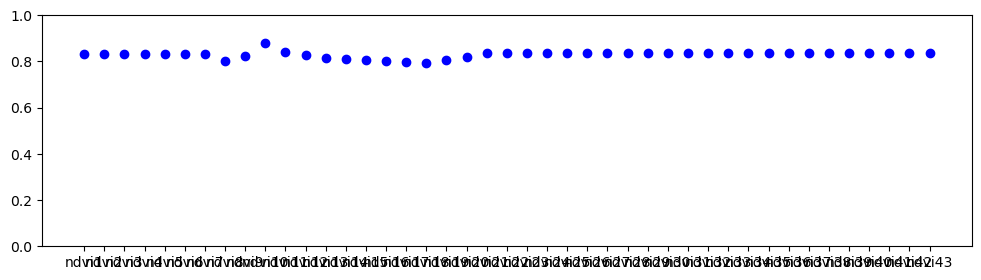

In [31]:
x = submission_ndvi_data[150:151]
plt.figure(figsize=(12,3))
plt.ylim(0.0 , 1.0)
plt.scatter(y,x, c ="blue");

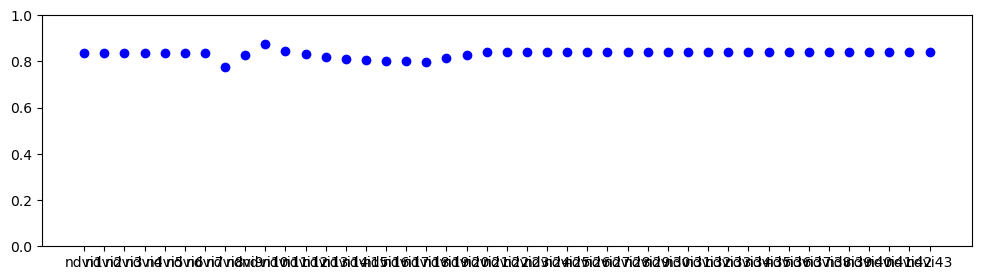

In [32]:
x = submission_ndvi_data[125:126]
plt.figure(figsize=(12,3))
plt.ylim(0.0 , 1.0)
plt.scatter(y,x, c ="blue");

In [33]:
# Save dataframe to CSV file for future use
submission_ndvi_data.to_csv('submission_landsat_cloud_filter_ndvi_43Columns_2021-11-01_2022-05-30.csv',index = False)